In [ ]:
import torch
import pathlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

In [9]:
from vit_pytorch import ViT

In [3]:
import sys
sys.path.append('models') 


In [6]:
from binae import BinModel

In [5]:
THRESHOLD = 0.5 ## binarization threshold after the model output

SPLITSIZE =  256  ## your image will be divided into patches of 256x256 pixels
setting = "base"  ## choose the desired model size [small, base or large], depending on the model you want to use
patch_size = 16 ## choose your desired patch size [8 or 16], depending on the model you want to use
image_size =  (SPLITSIZE,SPLITSIZE)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
if setting == 'base':
    encoder_layers = 6
    encoder_heads = 8
    encoder_dim = 768

if setting == 'small':
    encoder_layers = 3
    encoder_heads = 4
    encoder_dim = 512

if setting == 'large':
    encoder_layers = 12
    encoder_heads = 16
    encoder_dim = 1024

In [10]:
v = ViT(
    image_size = image_size,
    patch_size = patch_size,
    num_classes = 1000,
    dim = encoder_dim,
    depth = encoder_layers,
    heads = encoder_heads,
    mlp_dim = 2048
)
model = BinModel(
    encoder = v,
    decoder_dim = encoder_dim,      
    decoder_depth = encoder_layers,
    decoder_heads = encoder_heads       
)

model = model.to(device)

In [ ]:
model_path = "best-model_16_2016base_256_16.pt" # model weights
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)


<All keys matched successfully>

## INPUT

In [34]:
deg_folder = 'degraded/'
image_name = '14.png'
deg_image = cv2.imread(deg_folder+image_name) / 255

In [35]:
def split(im,h,w):
    patches=[]
    nsize1=SPLITSIZE
    nsize2=SPLITSIZE
    for ii in range(0,h,nsize1): #2048
        for iii in range(0,w,nsize2): #1536
            patches.append(im[ii:ii+nsize1,iii:iii+nsize2,:])
    
    return patches 

def merge_image(splitted_images, h,w):
    image=np.zeros(((h,w,3)))
    nsize1=SPLITSIZE
    nsize2=SPLITSIZE
    ind =0
    for ii in range(0,h,nsize1):
        for iii in range(0,w,nsize2):
            image[ii:ii+nsize1,iii:iii+nsize2,:]=splitted_images[ind]
            ind += 1
    return image  

In [36]:
h =  ((deg_image.shape[0] // 256) +1)*256 
w =  ((deg_image.shape[1] // 256 ) +1)*256
deg_image_padded=np.ones((h,w,3))
deg_image_padded[:deg_image.shape[0],:deg_image.shape[1],:]= deg_image
patches = split(deg_image_padded, deg_image.shape[0], deg_image.shape[1])

In [37]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

out_patches=[]
for p in patches:
    out_patch = np.zeros([3, *p.shape[:-1]])
    for i in range(3):
        out_patch[i] = (p[:,:,i] - mean[i]) / std[i]
    out_patches.append(out_patch)

In [38]:
result = []
for patch_idx, p in enumerate(out_patches):
    print(f"({patch_idx} / {len(out_patches) - 1}) processing patch...")
    p = np.array(p, dtype='float32')
    train_in = torch.from_numpy(p)

    with torch.no_grad():
        train_in = train_in.view(1,3,SPLITSIZE,SPLITSIZE).to(device)
        _ = torch.rand((train_in.shape)).to(device)
        loss,_, pred_pixel_values = model(train_in,_)
        rec_patches = pred_pixel_values
        rec_image = torch.squeeze(rearrange(rec_patches, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)', p1 = patch_size, p2 = patch_size,  h=image_size[0]//patch_size))
        impred = rec_image.cpu().numpy()
        impred = np.transpose(impred, (1, 2, 0))
        for ch in range(3):
            impred[:,:,ch] = (impred[:,:,ch] *std[ch]) + mean[ch]
        impred[np.where(impred>1)] = 1
        impred[np.where(impred<0)] = 0
    result.append(impred)

(0 / 59) processing patch...
(1 / 59) processing patch...
(2 / 59) processing patch...
(3 / 59) processing patch...
(4 / 59) processing patch...
(5 / 59) processing patch...
(6 / 59) processing patch...
(7 / 59) processing patch...
(8 / 59) processing patch...
(9 / 59) processing patch...
(10 / 59) processing patch...
(11 / 59) processing patch...
(12 / 59) processing patch...
(13 / 59) processing patch...
(14 / 59) processing patch...
(15 / 59) processing patch...
(16 / 59) processing patch...
(17 / 59) processing patch...
(18 / 59) processing patch...
(19 / 59) processing patch...
(20 / 59) processing patch...
(21 / 59) processing patch...
(22 / 59) processing patch...
(23 / 59) processing patch...
(24 / 59) processing patch...
(25 / 59) processing patch...
(26 / 59) processing patch...
(27 / 59) processing patch...
(28 / 59) processing patch...
(29 / 59) processing patch...
(30 / 59) processing patch...
(31 / 59) processing patch...
(32 / 59) processing patch...
(33 / 59) processing

In [39]:

clean_image = merge_image(result, deg_image_padded.shape[0], deg_image_padded.shape[1])
clean_image = clean_image[:deg_image.shape[0], :deg_image.shape[1],:]
clean_image = (clean_image>THRESHOLD)*255


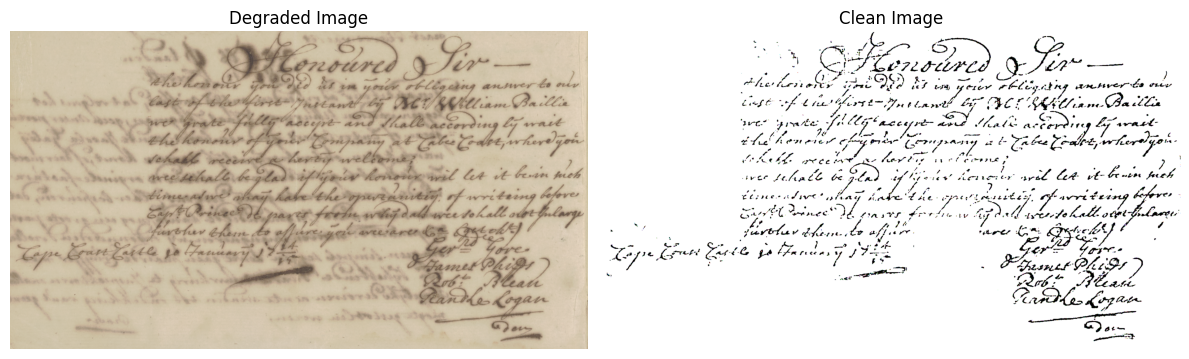

In [40]:
import matplotlib.pyplot as plt

# Assuming clean_image and deg_image are already defined
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the degraded image (reordering channels to RGB)
ax[0].imshow(deg_image[:, :, [2, 1, 0]])  # Reordering channels for RGB
ax[0].set_title('Degraded Image')
ax[0].axis('off')

# Plot the clean image
ax[1].imshow(clean_image)
ax[1].set_title('Clean Image')
ax[1].axis('off')


plt.tight_layout()
plt.show()
